In [1]:
import os
import sys
import pickle
import numpy as np
from scipy.io.matlab import loadmat
from scipy.sparse import csr_matrix
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.markers import MarkerStyle
import itertools

from almc.bayesian_rescal import PFBayesianRescal, compute_regret
%matplotlib inline

In [2]:
def load_dataset(dataset):
    if dataset == 'umls':
        mat = loadmat('../data/%s/uml.mat' % (dataset))
        T = np.array(mat['Rs'], np.float32)
    elif dataset == 'nation':
        mat = loadmat('../data/%s/dnations.mat' % (dataset))
        T = np.array(mat['R'], np.float32)
    elif dataset == 'kinship':
        mat = loadmat('../data/%s/alyawarradata.mat' % (dataset))
        T = np.array(mat['Rs'], np.float32)
    elif dataset == 'wordnet':
        T = pickle.load(open('../data/%s/reduced_wordnet.pkl' % (dataset), 'rb'))
    elif dataset == 'freebase':
        T, _, _ = pickle.load(open('../data/freebase/subset_5000.pkl', 'rb'))

    if dataset == 'umls' or dataset == 'nation' or dataset == 'kinship':
        T = np.swapaxes(T, 1, 2)
        T = np.swapaxes(T, 0, 1)  # [relation, entity, entity]
        T[np.isnan(T)] = 0
    return T

In [3]:
color = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]    
  
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
for i in range(len(color)):    
    r, g, b = color[i]    
    color[i] = (r / 255., g / 255., b / 255.)

In [4]:
model_var_comp = dict()
# model_var_comp[('nation', 'bcomp_mul')] = 100.00
model_var_comp[('nation', 'bcomp_mul')] = 1.00   # for the additional mcmc steps
model_var_comp[('kinship', 'bcomp_mul')] = 100.00
model_var_comp[('nation', 'bcomp_add')] = 10000.00
model_var_comp[('kinship', 'bcomp_add')] = 10000.00
# model_var_comp[('umls', 'bcomp_mul')] = 1.00
model_var_comp[('umls', 'bcomp_mul')] = 10.00    # for the additional mcmc steps
model_var_comp[('umls', 'bcomp_add')] = 1.00
dataset_limit = dict()
dataset_limit['nation'] = 2000
dataset_limit['kinship'] = 10000
dataset_limit['umls'] = 10000

model_colors = {'brescal':color[0], 'amdc_pop':color[14], 'amdc_pred':color[7], 'bcomp_mul':color[2], 'bcomp_add':color[3], 'logit':color[5], 'brescal_passive':'k'}
model_names = {'brescal':'bnormal', 'amdc_pop':'amdc_pop', 'amdc_pred':'amdc_pred', 'bcomp_mul':'bcomp_mul', 'bcomp_add':'bcomp_add', 'logit':'blogit', 'brescal_passive':'brescal_passive'}

# PLOTPLOTPLOT!

/Users/arongdari/.python3/lib/python3.4/site-packages/ipykernel/__main__.py:71: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/arongdari/.python3/lib/python3.4/site-packages/ipykernel/__main__.py:73: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


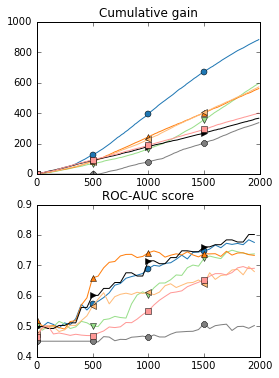

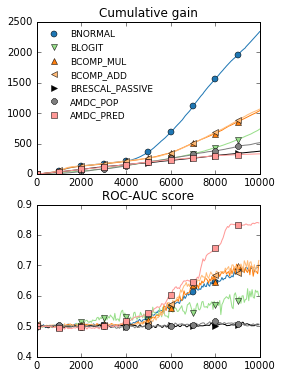

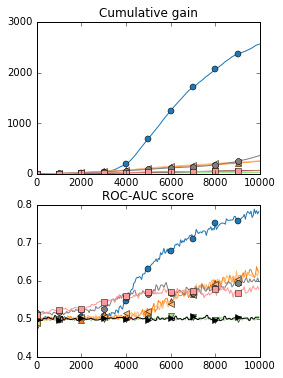

In [5]:
legend_size = 9
plt_gap = 10
auc_plt_gap = 50
title_size = 12
marker_gap = 1000
#linestyles = ['--', '-.', '-.', ':', '-', '-']
markers = ('o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd')

vertical=True
datasets = ['nation', 'kinship', 'umls']
#models = ['brescal', 'bcomp_mul', 'amdc_pop', 'amdc_pred']
#models = ['brescal', 'bcomp_mul', 'bcomp_add', 'brescal_passive','amdc_pop', 'amdc_pred']
models = ['brescal', 'logit', 'bcomp_mul', 'bcomp_add', 'brescal_passive','amdc_pop', 'amdc_pred']

for dataset in datasets:
    if dataset is 'nation':
        marker_gap = 500
    else:
        marker_gap = 1000
        
    T = load_dataset(dataset)

    n_test = 5
    x_lim = dataset_limit[dataset]
    summary = dict()
    auc_summary = dict()
    min_len = dict()
    for model in models:
        summary[model] = np.zeros([n_test, x_lim])
        auc_summary[model] = np.zeros([n_test, x_lim])
        min_len[model] = x_lim

    for nt in range(n_test):  

        for model in models:
            if model == 'brescal':
                auc_file = '../result/%s/brescal/train_test_varx_0.10_dim_10_par_5_test_%d_eval.txt' % (dataset, nt)
                query_file = '../result/%s/brescal/train_test_varx_0.10_dim_10_par_5_test_%d.txt' %(dataset, nt)
            elif model == 'bcomp_mul': 
                var_comp = model_var_comp[(dataset,model)]
                auc_file = '../result/%s/%s/train_test_var_0.10_%.2f_dim_10_par_5_test_%d_eval.txt' %(dataset, model, var_comp, nt)
                query_file = '../result/%s/%s/train_test_var_0.10_%.2f_dim_10_par_5_test_%d.txt' %(dataset, model, var_comp, nt)   
                # for the additional mcmc steps
                auc_file = '../result/%s/%s/train_test_var_0.10_%.2f_dim_10_par_1_test_%d_mc_10_eval.txt' %(dataset, model, var_comp, nt)
                query_file = '../result/%s/%s/train_test_var_0.10_%.2f_dim_10_par_1_test_%d_mc_10.txt' %(dataset, model, var_comp, nt)   
            elif model == 'bcomp_add':
                var_comp = model_var_comp[(dataset,model)]
                if dataset == 'umls':
                    auc_file = '../result/%s/%s/train_test_var_0.10_%.2f_dim_10_par_5_test_%d_eval.txt' %(dataset, model, var_comp, nt)
                    query_file = '../result/%s/%s/train_test_var_0.10_%.2f_dim_10_par_5_test_%d.txt' %(dataset, model, var_comp, nt)                                                            
                else:
                    auc_file = '../result/%s/%s/train_test_var_0.10_%.2f_dim_10_par_5_test_%d_mc_move_5_eval.txt' %(dataset, model, var_comp, nt)
                    query_file = '../result/%s/%s/train_test_var_0.10_%.2f_dim_10_par_5_test_%d_mc_move_5.txt' %(dataset, model, var_comp, nt)                                        
            elif model == 'amdc_pop':
                auc_file = '../result/%s/amdc_pn/auc_population_train_0.000_test_0.300_10_%d.txt' % (dataset, nt)
                query_file = '../result/%s/amdc_pn/query_population_train_0.000_test_0.300_10_%d.txt' %(dataset, nt)            
            elif model == 'amdc_pred':
                auc_file = '../result/%s/amdc_pn/auc_predictive_train_0.000_test_0.300_10_%d.txt' % (dataset, nt)
                query_file = '../result/%s/amdc_pn/query_predictive_train_0.000_test_0.300_10_%d.txt' %(dataset, nt)
            elif model == 'brescal_passive':
                auc_file = '../result/%s/brescal_passive/train_test_varx_0.10_dim_10_test_%d_eval.txt' % (dataset, nt)
                query_file = '../result/%s/brescal_passive/train_test_varx_0.10_dim_10_test_%d.txt' %(dataset, nt)            
            elif model == 'logit':
                auc_file = '../result/%s/%s/train_test_dim_10_par_5_test_%d_eval.txt' % (dataset, model, nt)
                query_file = '../result/%s/%s/train_test_dim_10_par_5_test_%d.txt' %(dataset, model, nt)                            
            else:
                raise Error('There is no such model')

            seq = [line.split(',') for line in open(query_file, 'r').readlines()]
            if not model.startswith('amdc'):
                cum_sum = np.cumsum([T[s] for s in seq])
            else:
                cum_sum = np.cumsum([T[s[2],s[0],s[1]] for s in seq])

            x_min = min(len(cum_sum), x_lim)

            summary[model][nt, :x_min] = cum_sum[:x_min]
            auc_sum = [float(x) for x in open(auc_file).readlines()]
            x_min = min(x_min, len(auc_sum))

            auc_summary[model][nt, :x_min] = auc_sum[:x_min]

            if min_len[model] > x_min:
                min_len[model] = x_min
    if vertical:
        fig = plt.figure(figsize=(4,6))        
    else:
        fig = plt.figure(figsize=(12,3))
#     plt.suptitle(dataset.upper())
    for model in models:
        cum_sum = np.mean(summary[model], 0)[:min_len[model]]

        _color = model_colors[model]
        model_name = model_names[model].upper()

        if vertical:
            plt.subplot(2, 1, 1)        
        else:
            plt.subplot(1, 2, 1)

        plt.plot(np.arange(0,len(cum_sum), plt_gap), cum_sum[::plt_gap], color=_color)
        plt.plot(np.arange(0,len(cum_sum), marker_gap), cum_sum[::marker_gap], markers[models.index(model)], label=model_name, color=_color)
#         plt.plot(np.arange(models.index(model)*100, len(cum_sum), marker_gap), cum_sum[models.index(model)*100:len(cum_sum):marker_gap], markers[models.index(model)], label=model.upper(), color=_color)
        plt.title('Cumulative gain', size=title_size)
        plt.xlim([0,x_lim])
        plt.locator_params(axis = 'y', nbins = 5)
        plt.locator_params(axis = 'x', nbins = 6) 
        
        if vertical:
            plt.subplot(2, 1, 2)
        else:
            plt.subplot(1, 2, 2)
        auc = np.mean(auc_summary[model], 0)[:min_len[model]]
        plt.plot(np.arange(0,len(auc), auc_plt_gap), auc[::auc_plt_gap], color=_color)
        plt.plot(np.arange(0,len(auc), marker_gap), auc[::marker_gap], markers[models.index(model)], label=model_name, color=_color)
#        plt.plot(np.arange(models.index(model)*100,len(auc), marker_gap), auc[models.index(model)*100:len(auc):marker_gap], markers[models.index(model)], label=model.upper(), color=_color)        
        plt.title('ROC-AUC score', size=title_size)
        plt.xlim([0,x_lim])
        plt.locator_params(axis = 'y', nbins = 5)
        plt.locator_params(axis = 'x', nbins = 6)
        
    if dataset == 'kinship':
        if vertical:
            plt.subplot(2, 1, 1)
        else:
            plt.subplot(1, 2, 1)
        plt.legend(loc='upper left', numpoints=1, frameon=False, prop={'size':legend_size})
    if vertical:
        plt.savefig('../paper/images/thompson_%s_mcmc_vertical.pdf' % (dataset), format='PDF', bbox_inches='tight', pad_inches=0.1)
    else:
        plt.savefig('../paper/images/thompson_%s_mcmc.pdf' % (dataset), format='PDF', bbox_inches='tight', pad_inches=0.1)

# Plot nation with various MCMC iterations

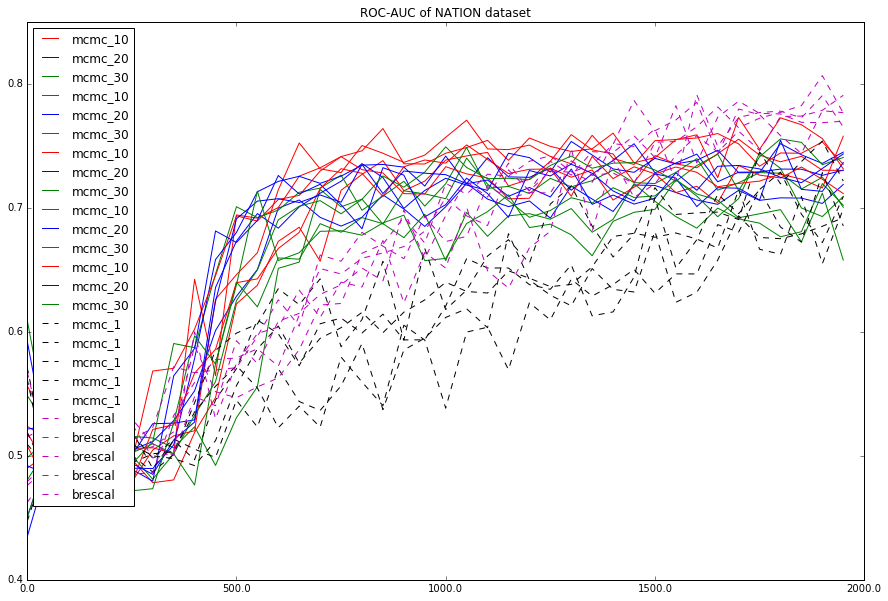

In [26]:
n_test = range(5)
var_xs = [0.1]
var_comps = [1]
mcmcs = [10,20,30]
plt_gap = 50
x_lim = 2000
x_nticks = 5
aucfile_format = '../result/nation/bcomp_mul/train_test_var_%.2f_%.2f_dim_10_par_1_test_%d_mc_%d_eval.txt'

fig = plt.figure(figsize=(15,10))
for var_x, var_comp, nt, mcmc in itertools.product(var_xs, var_comps, n_test, mcmcs):
    auc_file = aucfile_format % (var_x, var_comp, nt, mcmc)
    if os.path.exists(auc_file):
        auc = [float(x) for x in open(auc_file).readlines()]
        if mcmc==10:
            color='red'
        elif mcmc==20:
            color='blue'
        elif mcmc==30:
            color='green'

        plt.plot(auc[:x_lim:plt_gap], color=color, label = 'mcmc_%d' % (mcmc))

aucfile_format = '../result/nation/bcomp_mul/train_test_var_0.10_100.00_dim_10_par_5_test_%d_eval.txt'
for nt in n_test:
    auc_file = aucfile_format % (nt)

    if os.path.exists(auc_file):
        auc = [float(x) for x in open(auc_file).readlines()]
        color = 'black'

        plt.plot(auc[:x_lim:plt_gap], '--', color=color, label = 'mcmc_1')

aucfile_format = '../result/nation/brescal/train_test_varx_0.10_dim_10_par_5_test_%d_eval.txt'
for nt in n_test:
    auc_file = aucfile_format % (nt)

    if os.path.exists(auc_file):
        auc = [float(x) for x in open(auc_file).readlines()]
        color = 'm'
        plt.plot(auc[:x_lim:plt_gap], '--', color=color, label = 'brescal')

plt.xlim([0,x_lim/plt_gap])
plt.xticks(np.linspace(0, x_lim/plt_gap, x_nticks), np.linspace(0, x_lim, x_nticks))
plt.title('ROC-AUC of NATION dataset')
plt.legend(loc='upper left')

/Users/arongdari/.python3/lib/python3.4/site-packages/ipykernel/__main__.py:17: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/arongdari/.python3/lib/python3.4/site-packages/ipykernel/__main__.py:34: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/arongdari/.python3/lib/python3.4/site-packages/ipykernel/__main__.py:45: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


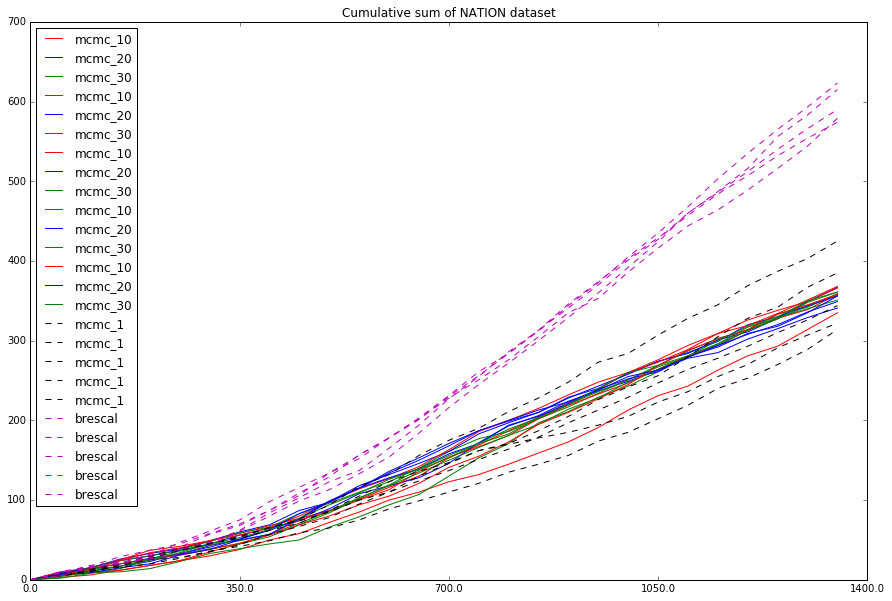

In [27]:
n_test = range(5)
var_xs = [0.1]
var_comps = [1]
mcmcs = [10,20,30]
plt_gap = 50
x_lim = 1400
x_nticks = 5
file_format = '../result/nation/bcomp_mul/train_test_var_%.2f_%.2f_dim_10_par_1_test_%d_mc_%d.txt'

T = load_dataset('nation')

fig = plt.figure(figsize=(15,10))
for var_x, var_comp, nt, mcmc in itertools.product(var_xs, var_comps, n_test, mcmcs):
    query_file = file_format % (var_x, var_comp, nt, mcmc)
    if os.path.exists(query_file):
        seq = [line.split(',') for line in open(query_file, 'r').readlines()]
        cum_sum = np.cumsum([T[s] for s in seq])

        if mcmc==10:
            color='red'
        elif mcmc==20:
            color='blue'
        elif mcmc==30:
            color='green'

        plt.plot(cum_sum[:x_lim:plt_gap], color=color, label = 'mcmc_%d' % (mcmc))

file_format = '../result/nation/bcomp_mul/train_test_var_0.10_100.00_dim_10_par_5_test_%d.txt'
for nt in n_test:
    query_file = file_format % (nt)

    if os.path.exists(query_file):
        seq = [line.split(',') for line in open(query_file, 'r').readlines()]
        cum_sum = np.cumsum([T[s] for s in seq])
        color = 'black'

        plt.plot(cum_sum[:x_lim:plt_gap], '--', color=color, label = 'mcmc_1')

file_format = '../result/nation/brescal/train_test_varx_0.10_dim_10_par_5_test_%d.txt'
for nt in n_test:
    query_file = file_format % (nt)

    if os.path.exists(query_file):
        seq = [line.split(',') for line in open(query_file, 'r').readlines()]
        cum_sum = np.cumsum([T[s] for s in seq])

        color = 'm'
        plt.plot(cum_sum[:x_lim:plt_gap], '--', color=color, label = 'brescal')

plt.xlim([0,x_lim/plt_gap])
plt.xticks(np.linspace(0, x_lim/plt_gap, x_nticks), np.linspace(0, x_lim, x_nticks))
plt.legend(loc='upper left')
plt.title('Cumulative sum of NATION dataset')